<img style="float: left;" src="resources/made.jpg" width="35%" height="35%">

# Академия MADE
## Семинар 14: ускорение тренировки и применения сетей
Иван Карпухин, ведущий программист-исследователь команды машинного зрения

<div style="clear:both;"></div>

В рамках семинара разберемся в основных проблемах с производительностью, посмотрим, как учить сети на нескольких GPU и научимся квантовать сети.

Для выполнения работы нужны следующие пакеты (Python 3):
* wget
* tarfile
* opencv-python
* pytorch_lightning
* torch
* torchvision

Установить их можно командой:
```bash
pip3 install --user wget tarfile opencv-python pytorch_lightning torch torchvision
```

In [107]:
%matplotlib inline
import inspect
import os
import random

import cv2
import pytorch_lightning as pl
import torch
import torchvision
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

import seminar

print("Torch", torch.__version__)

USE_CUDA = torch.cuda.is_available()
if USE_CUDA:
    print("Use CUDA")

def set_figure_size(figsize=(8, 6), dpi=120):
    plt.figure(figsize=figsize, dpi=dpi)

Torch 1.5.0
Use CUDA


In [2]:
# Debug.
import imp
seminar = imp.reload(seminar)

# Загрузка данных

In [3]:
import wget
import tarfile
DATASET = "imagenetv2-matched-frequency"
DATA_URL = "https://s3-us-west-2.amazonaws.com/imagenetv2public/{}.tar.gz".format(DATASET)
if not os.path.isdir(DATASET):
    print("Download {}".format(DATA_URL))
    filename = wget.download(DATA_URL, out="{}.tar".format(DATASET))
    print("Extract {}".format(filename))
    with tarfile.open(filename) as fp:
        fp.extractall()
    print("Done")
else:
    print("Use cached data")

torchvision.models.resnet101(pretrained=True)
pass

Use cached data


# Создание корпуса

Total dataset size: 10000
Used dataset size: 1000


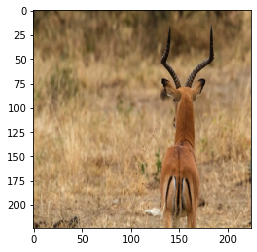

In [4]:
info_dataset = seminar.ImageNetDataset("imagenetv2-matched-frequency")
print("Total dataset size: {}".format(len(info_dataset)))

dataset = seminar.ImageNetDataset("imagenetv2-matched-frequency", num_samples=1000, to_tensor=True)
print("Used dataset size: {}".format(len(dataset)))

image, label = info_dataset[random.randrange(0, len(info_dataset))]
plt.imshow(image)
plt.show()

# Создание модели

In [5]:
model = torchvision.models.resnet101(pretrained=True)
if USE_CUDA:
    model.cuda()
seminar.model_info(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

# Простые способы ускорения вывода

### Dataloader со стандартными настройками

In [6]:
dataloader = torch.utils.data.DataLoader(dataset)
seminar.eval_model(model, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:17<00:00, 58.32it/s]

Speed: 17.151 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


### Увеличим размер batch-а
За счет праллелизма большой batch обрабатывается быстрее нескольких маленьких.

In [7]:
BATCH_SIZE = 32

In [8]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE)
seminar.eval_model(model, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.19it/s]

Speed: 7.647 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


### Увеличим число процессов подготовки данных
Изначально данные загружались и форматировались в том же процессе, что и тренировка. Во время подготовки данных, нейронная сеть простаивала. Теперь данные будут готовиться в других процессах параллельно с применением сети.

In [9]:
NUM_WORKERS = 4

In [10]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS)
seminar.eval_model(model, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 11.74it/s]

Speed: 2.730 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


### Включим привязку памяти (page-locked memory aka "pinned" memory)
http://www.orangeowlsolutions.com/archives/443

В оперативной памяти резервируется область, куда кладутся данные для обработки. При этом не используется механизм виртуальной памяти, что ускоряет обмен данными между CPU и GPU.

In [11]:
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:02<00:00, 12.44it/s]

Speed: 2.576 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


### Воспользуемся половинной точностью (half precision, FP16)
Некоторые GPU поддерживают быстрые вычисления в половинной точности. Можно конертировать веса модели и данные во float16 перед применением. При этом качество предсказаний может измениться.

FP16 позволяет также увеличить размер batch-а.

In [12]:
model_fp16 = torchvision.models.resnet101(pretrained=True)
model_fp16 = model_fp16.half()
if USE_CUDA:
    model_fp16.cuda()
dataset_fp16 = seminar.ImageNetDataset("imagenetv2-matched-frequency",
                                       num_samples=1000, to_tensor=True, fp16=True)

In [13]:
dataloader = torch.utils.data.DataLoader(dataset_fp16,
                                         batch_size=BATCH_SIZE,
                                         num_workers=NUM_WORKERS,
                                         pin_memory=USE_CUDA)
seminar.eval_model(model_fp16, dataloader)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [00:03<00:00,  9.16it/s]

Speed: 3.495 ms per sample
Top 1 accuracy: 0.654
Top 5 accuracy: 0.851


С fp16 вывод даже замедлился. Реализация FP16 в PyTorch не полностью использует возможности GPU и создана для ускорения обучения.

# Простые способы ускорения тренировки

In [14]:
print(inspect.getsource(seminar.Estimator))

class Estimator(pl.LightningModule):
    """Модуль, объединяющий модель, данные и оптимизацию."""
    def __init__(self, model, dataset, batch_size, num_workers):
        super().__init__()
        self._model = model
        self._dataset = dataset
        self._batch_size = batch_size
        self._num_workers = num_workers
        self._loss = torch.nn.CrossEntropyLoss()
        self._start_time = None
        self._num_samples = 0

    def forward(self, images):
        return self._model(images)
    
    @pl.data_loader
    def train_dataloader(self):
        return torch.utils.data.DataLoader(self._dataset,
                                           batch_size=self._batch_size,
                                           num_workers=self._num_workers,
                                           pin_memory=USE_CUDA)
    
    def training_step(self, batch, batch_idx, optimizer_idx=None):
        if self._start_time is None:
            self._start_time = time.time()
        images, l

### FP32

In [15]:
estimator = seminar.Estimator(model, dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
trainer = pl.Trainer(max_epochs=1,
                     gpus="0" if USE_CUDA else None)
trainer.fit(estimator)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

    | Name                         | Type              | Params
---------------------------------------------------------------
0   | _model                       | ResNet            | 44 M  
1   | _model.conv1                 | Conv2d            | 9 K   
2   | _model.bn1                   | BatchNorm2d       | 128   
3   | _model.relu                  | ReLU              | 0     
4   | _model.maxpool               | MaxPool2d         | 0     
5   | _model.layer1                | Sequential        | 215 K 
6   | _model.layer1.0              | Bottleneck        | 75 K  
7   | _model.layer1.0.conv1        | Conv2d            | 4 K   
8   | _model.layer1.0.bn1          | BatchNorm2d       | 128   
9   | _model.layer1.0.conv2        | Conv2d            | 36 K  
10  | _model.layer1.0.bn2          | BatchNorm2d       | 128   
11  | _model.layer1.0.conv3        | Conv2d         

Speed: 7.576 ms per sample (total 1000 samples)


/home/ivan.karpukhin/.local/lib/python3.6/site-packages/pytorch_lightning/utilities/distributed.py:23: UserWarning: Did not find hyperparameters at model hparams. Saving checkpoint without hyperparameters.
  warnings.warn(*args, **kwargs)


1

### FP16

In [16]:
estimator = seminar.Estimator(model_fp16, dataset_fp16, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)
trainer = pl.Trainer(max_epochs=1,
                     gpus="0" if USE_CUDA else None,
                     precision=16,
                     use_amp=False)
trainer.fit(estimator)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0]

    | Name                         | Type              | Params
---------------------------------------------------------------
0   | _model                       | ResNet            | 44 M  
1   | _model.conv1                 | Conv2d            | 9 K   
2   | _model.bn1                   | BatchNorm2d       | 128   
3   | _model.relu                  | ReLU              | 0     
4   | _model.maxpool               | MaxPool2d         | 0     
5   | _model.layer1                | Sequential        | 215 K 
6   | _model.layer1.0              | Bottleneck        | 75 K  
7   | _model.layer1.0.conv1        | Conv2d            | 4 K   
8   | _model.layer1.0.bn1          | BatchNorm2d       | 128   
9   | _model.layer1.0.conv2        | Conv2d            | 36 K  
10  | _model.layer1.0.bn2          | BatchNorm2d       | 128   
11  | _model.layer1.0.conv3        | Conv2d         

Speed: 5.411 ms per sample (total 1000 samples)



1

Тренировка ускоряется (при наличии подходящей GPU) примерно на 30%.

Алгоритм Карацубы позволяет умножать fp16 в 3 раза быстрее, чем fp32:
https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B3%D0%BE%D1%80%D0%B8%D1%82%D0%BC_%D0%9A%D0%B0%D1%80%D0%B0%D1%86%D1%83%D0%B1%D1%8B

Опять, реализация FP16 в PyTorch не полностью использует возможности GPU.

Использование NVIDIA APEX (флаг use_amp) может повысить производительность.

## Использование нескольких GPU

In [18]:
TRAIN_BATCH_SIZE = 32
estimator = seminar.Estimator(model_fp16, dataset_fp16, batch_size=TRAIN_BATCH_SIZE, num_workers=NUM_WORKERS)
trainer = pl.Trainer(max_epochs=1,
                     gpus="0,1" if USE_CUDA else None,
                     precision=16,
                     use_amp=False)
trainer.fit(estimator)

GPU available: True, used: True
No environment variable for node rank defined. Set as 0.
CUDA_VISIBLE_DEVICES: [0,1]


1

\# Speed: 6.693 ms per sample (total 500 samples)

\# Speed: 6.748 ms per sample (total 500 samples)

Время обработки семпла немного выросло, но каждый процесс обрабатывает только половину корпуса.

# Квантование Int8

In [110]:
def as_int8(X):
    return np.around(X.clip(-128, 127)).astype(np.int8)

def mul_int8(A, X, scale_prod):
    """Умножение должно правильно обрабатывать переполнение."""
    Y = A.astype(np.int32) @ X.astype(np.int32).T
    return as_int8(Y * scale_prod)

def eval_quantization(A, X, scale_A, scale_X, scale_prod, verbose=True):
    Y_gt = A @ X.T
    A8 = as_int8(scale_A * A)
    X8 = as_int8(scale_X * X)
    Y8 = mul_int8(A8, X8, scale_prod)
    Y = Y8.astype(np.float32) / scale_prod / scale_A / scale_X
    l2 = np.linalg.norm(Y - Y_gt)
    if verbose:
        print("Scale A:", scale_A)
        print("Scale X:", scale_X)
        print("Scale prod:", scale_prod)
        print("L2:", l2)
    return l2

In [ ]:
STD_A = 5
STD_X = 3

A = np.random.randn(20, 10) * STD_A
X = np.random.randn(5000, 10) * STD_X

In [111]:
eval_quantization(A, X, 1, 1, 1)

Scale A: 1
Scale X: 1
Scale prod: 1
L2: 2037.6383769405315


2037.6383769405315

Самая простая стратегия: отмасштабировать так, чтобы min и max попадали в интервал квантования.

In [112]:
max_A = np.max(np.abs(A))
max_X = np.max(np.abs(X))
eval_quantization(A, X, 127 / max_A, 127 / max_X, 3 / 127 / A.shape[1])

Scale A: 8.507358729361854
Scale X: 9.88274392920862
Scale prod: 0.002362204724409449
L2: 493.7517882905162


493.7517882905162

Можно воспользоваться нормальностью значений A и X.

A ~ N(0, VarA)

X ~ N(0, VarX)

A1 X1 + A2 X2 + ... + Ak Xk ~ N(0, k VarA VarX)

Приведем A, X и результат скалярного произведения к фиксированному STD.

In [151]:
STD = 127 / 4
k = A.shape[1]
eval_quantization(A, X, STD / np.std(A), STD / np.std(X), 1 / STD / np.sqrt(k))

Scale A: 6.061884878007724
Scale X: 10.533278122926209
Scale prod: 0.009959929638325603
L2: 271.50863481247967


271.50863481247967

Воспользуемся полным перебором

In [149]:
best = None
best_val = 1e9
for a_scale in tqdm(np.linspace(1, 19, 10)):
    for x_scale in np.linspace(1, 19, 10):
        for prod_scale in np.linspace(0.001, 0.01, 10):
            l2 = eval_quantization(A, X, a_scale, x_scale, prod_scale, verbose=False)
            if l2 < best_val:
                best_val = l2
                best = (a_scale, x_scale, prod_scale)
eval_quantization(A, X, *best)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:04<00:00,  2.37it/s]

Scale A: 7.0
Scale X: 11.0
Scale prod: 0.008
L2: 252.781241776726


252.781241776726

# Квантование TensorRT